<a href='http://moncoachdata.com'><img src= 'https://moncoachdata.com/wp-content/uploads/MonCoachData-cours/MonCoachData.jpg' width=400/></a>


---


<center><em>Copyright MonCoachData (tous droits réservés)</em></center>
<center><em>Pour plus d'informations, visitez notre site <a href='http://moncoachdata.com'>moncoachdata.com</a></em></center>



---

# KNN -  K Nearest Neighbors - Classification

Pour comprendre le KNN pour la classification, nous allons travailler avec un ensemble de données simple représentant les niveaux d'expression des gènes. Les niveaux d'expression des gènes sont calculés par le rapport entre l'expression du gène cible (c'est-à-dire le gène d'intérêt) et l'expression d'un ou plusieurs gènes de référence (souvent des gènes domestiques). Ce jeu de données est synthétique et spécifiquement conçu pour montrer certaines des forces et des limites de l'utilisation du KNN pour la classification.


Plus d'informations sur l'expression génétique : https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/gene-expression-level

## Importations

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Données

In [ ]:
df = pd.read_csv('gene_expression.csv')

In [ ]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


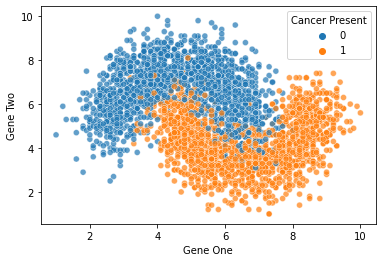

In [ ]:
sns.scatterplot(x='Gene One',y='Gene Two',hue='Cancer Present',data=df,alpha=0.7);

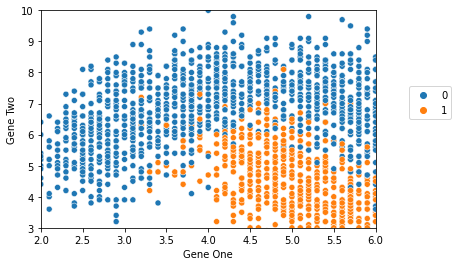

In [ ]:
sns.scatterplot(x='Gene One',y='Gene Two',hue='Cancer Present',data=df)
plt.xlim(2,6)
plt.ylim(3,10)
plt.legend(loc=(1.1,0.5));

## Fractionnement Entraînement | Test et Mise à l'échelle des Données

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
X = df.drop('Cancer Present',axis=1)
y = df['Cancer Present']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
scaler = StandardScaler()

In [ ]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=1)

In [ ]:
knn_model.fit(scaled_X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

# Compréhension du KNN et Choix de la valeur de K

In [ ]:
full_test = pd.concat([X_test,y_test],axis=1)

In [ ]:
len(full_test)

900

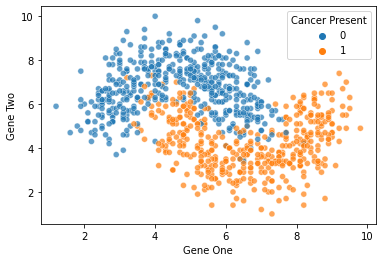

In [ ]:
sns.scatterplot(x='Gene One',y='Gene Two',hue='Cancer Present', data=full_test,alpha=0.7);

## Évaluation du Modèle

In [ ]:
y_pred = knn_model.predict(scaled_X_test)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [ ]:
accuracy_score(y_test,y_pred)

0.8911111111111111

In [ ]:
confusion_matrix(y_test,y_pred)

array([[422,  48],
       [ 50, 380]])

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       470
           1       0.89      0.88      0.89       430

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



## Méthode Elbow pour choisir des valeurs de K raisonnables

**NOTE : Ceci utilise le set de test pour la sélection de l'hyperparamètre K.**

In [ ]:
test_error_rates = []


for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_train,y_train) 
   
    y_pred_test = knn_model.predict(scaled_X_test)
    
    test_error = 1 - accuracy_score(y_test,y_pred_test)
    test_error_rates.append(test_error)

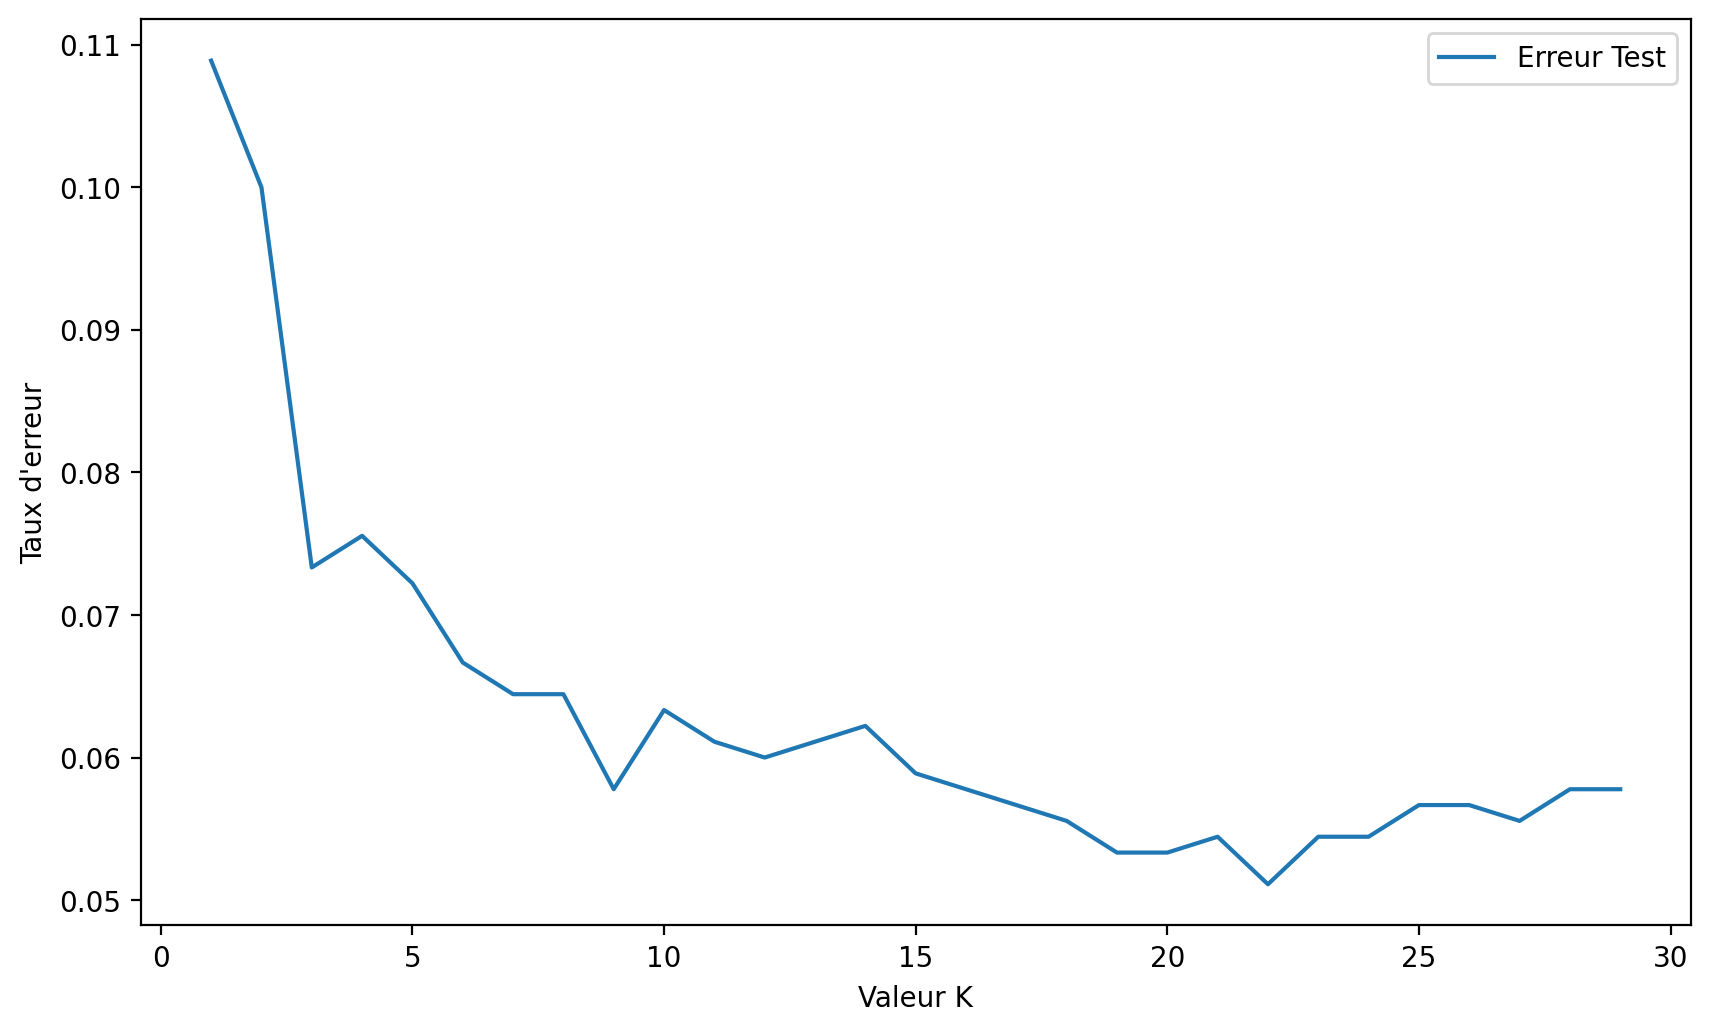

In [ ]:
plt.figure(figsize=(10,6),dpi=200)
plt.plot(range(1,30),test_error_rates,label='Erreur Test')
plt.legend()
plt.ylabel("Taux d'erreur")
plt.xlabel("Valeur K");

## Recherche de la valeur K dans une grille complète de validation croisée

### Création d'un pipeline pour trouver la valeur K

**Suivez très attentivement ce qui se passe ici ! Nous utilisons ici des codes de chaîne string ET des noms de variables très spécifiques afin que tout corresponde correctement. Il ne s'agit pas d'un cas où vous pouvez facilement remplacer les noms de variables par ce que vous voulez !**

Nous allons utiliser un objet Pipeline pour mettre en place un flux d'opérations :

1. Scale des Données
2. Création du Modèle sur les Données à l'échelle

----
**Comment fonctionne le Scaler dans un Pipeline avec CV ? Scikit-learn est-il assez "intelligent" pour comprendre que .fit() s'applique sur le set d'entraînement et .transform() sur les sets d'entraînement et de test ?**

**Oui ! Le pipeline de Scikit-Learn est bien adapté pour cela ! [Informations complètes dans la documentation](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)**

Lorsque vous utilisez le StandardScaler comme une étape à l'intérieur d'un pipeline, scikit-learn fera le travail en interne pour vous.

Ce qui se passe peut être décrit comme suit :

* Étape 0 : les données sont divisées en données TRAINING et données TEST selon le paramètre cv que vous avez spécifié dans le GridSearchCV.
* Étape 1 : le scaler est ajusté/adapté sur les données TRAINING.
* Étape 2 : le scaler transforme les données TRAINING.
* Étape 3 : les modèles sont entraînés en utilisant les données TRAINING transformées.
* Étape 4 : le scaler est utilisé pour transformer les données TEST.
* Étape 5 : les modèles entraînés prédisent en utilisant les données TEST transformées.

----

In [ ]:
scaler = StandardScaler()

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [ ]:
# Il est fortement recommandé que le code de la chaîne string corresponde au nom de la variable !
operations = [('scaler',scaler),('knn',knn)]

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
pipe = Pipeline(operations)

In [ ]:
from sklearn.model_selection import GridSearchCV

---
**Note : Si votre grille de paramètres entre dans un PipeLine, le nom de votre paramètre doit être spécifié de la manière suivante :**.

* nom_string_choisi + **deux** underscores + nom de la clé du paramètre
* nom_modèle + __ + nom du paramètre
* knn_model + __ + n_neighbors
* knn_model__n_neighbors

[StackOverflow sur ce sujet](https://stackoverflow.com/questions/41899132/invalid-parameter-for-sklearn-estimator-pipeline)

La raison pour laquelle nous devons faire cela est que cela permet à scikit-learn de savoir à quelle opération du pipeline ces paramètres sont liés (sinon il pourrait penser que n_neighbors est un paramètre du scaler).

---

In [ ]:
k_values = list(range(1,20))

In [ ]:
k_values

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [ ]:
param_grid = {'knn__n_neighbors': k_values}

In [ ]:
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy')

In [ ]:
# Utilisez X et y complets si vous ne voulez pas d'ensemble de test holdout.
# Utilisez X_train et y_train si vous voulez un ensemble de test holdout (X_test, y_test).
full_cv_classifier.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

In [ ]:
# K = 16 voisins (valeur optimal)
full_cv_classifier.best_estimator_.get_params()

{'knn': KNeighborsClassifier(n_neighbors=16),
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 16,
 'knn__p': 2,
 'knn__weights': 'uniform',
 'memory': None,
 'scaler': StandardScaler(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=16))],
 'verbose': False}

In [ ]:
full_cv_classifier.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_knn__n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

Vérifions notre compréhension :
**Quel est le nombre total d'exécutions que nous avons faites?**

In [ ]:
len(k_values)

19

In [ ]:
full_cv_classifier.cv_results_['mean_test_score']

array([0.90428571, 0.90619048, 0.92095238, 0.91333333, 0.92428571,
       0.92047619, 0.92428571, 0.92571429, 0.9247619 , 0.92238095,
       0.9247619 , 0.92380952, 0.92809524, 0.92857143, 0.92809524,
       0.92904762, 0.92857143, 0.92857143, 0.92714286])

In [ ]:
len(full_cv_classifier.cv_results_['mean_test_score'])

19

## Modèle Final

Nous venons de voir que notre GridSearch recommande un K=14 (en accord avec notre méthode alternative Elbow). Utilisons à nouveau le PipeLine, mais cette fois, il n'est pas nécessaire d'effectuer une recherche sur la grille, nous allons plutôt évaluer notre ensemble de test hold-out.

In [ ]:
scaler = StandardScaler()
knn14 = KNeighborsClassifier(n_neighbors=14)
operations = [('scaler',scaler),('knn14',knn14)]

In [ ]:
pipe = Pipeline(operations)

In [ ]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn14', KNeighborsClassifier(n_neighbors=14))])

In [ ]:
pipe_pred = pipe.predict(X_test)

In [ ]:
print(classification_report(y_test,pipe_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       470
           1       0.95      0.92      0.93       430

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



In [ ]:
single_sample = X_test.iloc[40]

In [ ]:
single_sample

Gene One    3.8
Gene Two    6.3
Name: 194, dtype: float64

In [ ]:
single_sample = [[3.8,6.3]]

In [ ]:
# Les données passées dans le pipeline possédaient les noms de features
# Il faut donc aussi ajouter les noms de colonnes/features à nos données sample

In [ ]:
# X_cols = X.columns
X_cols = ['Gene One', 'Gene Two']

In [ ]:
# On transforme notre tableau en un DataFrame avec les noms de colonne
single_sample = pd.DataFrame(data=single_sample, columns=X_cols)

In [ ]:
single_sample

,Gene One,Gene Two
0,3.8,6.3


In [ ]:
pipe.predict(single_sample)

array([0])

In [ ]:
pipe.predict_proba(single_sample)

array([[0.92857143, 0.07142857]])

----